<a href="https://colab.research.google.com/github/FentonLab/webChronux/blob/master/psd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyedflib

     |████████████████████████████████| 1.1MB 2.5MB/s 
  Created wheel for pyedflib: filename=pyEDFlib-0.1.17-cp36-cp36m-linux_x86_64.whl size=927027 sha256=2d1fbac8057206525f19451b7446199548854d396877edbb24e8ab8e670cc828
  Stored in directory: /root/.cache/pip/wheels/f8/f2/6b/ce6178c882779963f57d9764c3856b7cb63dd9995579be6b23
Successfully built pyedflib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pyedflib
from scipy import *
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import traceback
import scipy
from scipy.io import savemat, loadmat
from scipy import fftpack, linalg
SELECTED_CHANNELS = ['F7','T5', 'F3','P3', 'F4','P4', 'F8','T6', 'Fp1','O1', 'Fp2','O2']
import numpy as np
import os, sys, traceback
from google.colab import drive

In [0]:
def tridisolve(d, e, b, overwrite_b=True):
    """Symmetric tridiagonal system solver, from Golub and Van Loan pg 157.

    Note: Copied from NiTime

    Parameters
    ----------

    d : ndarray
      main diagonal stored in d[:]
    e : ndarray
      superdiagonal stored in e[:-1]
    b : ndarray
      RHS vector

    Returns
    -------

    x : ndarray
      Solution to Ax = b (if overwrite_b is False). Otherwise solution is
      stored in previous RHS vector b

    """
    N = len(b)
    # work vectors
    dw = d.copy()
    ew = e.copy()
    if overwrite_b:
        x = b
    else:
        x = b.copy()
    for k in range(1, N):
        # e^(k-1) = e(k-1) / d(k-1)
        # d(k) = d(k) - e^(k-1)e(k-1) / d(k-1)
        t = ew[k - 1]
        ew[k - 1] = t / dw[k - 1]
        dw[k] = dw[k] - t * ew[k - 1]
    for k in range(1, N):
        x[k] = x[k] - ew[k - 1] * x[k - 1]
    x[N - 1] = x[N - 1] / dw[N - 1]
    for k in range(N - 2, -1, -1):
        x[k] = x[k] / dw[k] - ew[k] * x[k + 1]

    if not overwrite_b:
        return x


def tridi_inverse_iteration(d, e, w, x0=None, rtol=1e-8):
    """Perform an inverse iteration.

    This will find the eigenvector corresponding to the given eigenvalue
    in a symmetric tridiagonal system.

    Note: Copied from NiTime

    Parameters
    ----------

    d : ndarray
      main diagonal of the tridiagonal system
    e : ndarray
      offdiagonal stored in e[:-1]
    w : float
      eigenvalue of the eigenvector
    x0 : ndarray
      initial point to start the iteration
    rtol : float
      tolerance for the norm of the difference of iterates

    Returns
    -------
    e: ndarray
      The converged eigenvector

    """
    eig_diag = d - w
    if x0 is None:
        x0 = np.random.randn(len(d))
    x_prev = np.zeros_like(x0)
    norm_x = np.linalg.norm(x0)
    # the eigenvector is unique up to sign change, so iterate
    # until || |x^(n)| - |x^(n-1)| ||^2 < rtol
    x0 /= norm_x
    while np.linalg.norm(np.abs(x0) - np.abs(x_prev)) > rtol:
        x_prev = x0.copy()
        tridisolve(eig_diag, e, x0)
        norm_x = np.linalg.norm(x0)
        x0 /= norm_x
    return x0


def dpss_windows(N, half_nbw, Kmax, low_bias=True, interp_from=None,
                 interp_kind='linear'):
    """Compute Discrete Prolate Spheroidal Sequences.

    Will give of orders [0,Kmax-1] for a given frequency-spacing multiple
    NW and sequence length N.

    Note: Copied from NiTime

    Parameters
    ----------
    N : int
        Sequence length
    half_nbw : float, unitless
        Standardized half bandwidth corresponding to 2 * half_bw = BW*f0
        = BW*N/dt but with dt taken as 1
    Kmax : int
        Number of DPSS windows to return is Kmax (orders 0 through Kmax-1)
    low_bias : Bool
        Keep only tapers with eigenvalues > 0.9
    interp_from : int (optional)
        The dpss can be calculated using interpolation from a set of dpss
        with the same NW and Kmax, but shorter N. This is the length of this
        shorter set of dpss windows.
    interp_kind : str (optional)
        This input variable is passed to scipy.interpolate.interp1d and
        specifies the kind of interpolation as a string ('linear', 'nearest',
        'zero', 'slinear', 'quadratic, 'cubic') or as an integer specifying the
        order of the spline interpolator to use.


    Returns
    -------
    v, e : tuple,
        v is an array of DPSS windows shaped (Kmax, N)
        e are the eigenvalues

    Notes
    -----
    Tridiagonal form of DPSS calculation from:

    Slepian, D. Prolate spheroidal wave functions, Fourier analysis, and
    uncertainty V: The discrete case. Bell System Technical Journal,
    Volume 57 (1978), 1371430
    """
    from scipy import interpolate
    Kmax = int(Kmax)
    W = float(half_nbw) / N
    nidx = np.arange(N, dtype='d')

    # In this case, we create the dpss windows of the smaller size
    # (interp_from) and then interpolate to the larger size (N)
    if interp_from is not None:
        if interp_from > N:
            e_s = 'In dpss_windows, interp_from is: %s ' % interp_from
            e_s += 'and N is: %s. ' % N
            e_s += 'Please enter interp_from smaller than N.'
            raise ValueError(e_s)
        dpss = []
        d, e = dpss_windows(interp_from, half_nbw, Kmax, low_bias=False)
        for this_d in d:
            x = np.arange(this_d.shape[-1])
            I = interpolate.interp1d(x, this_d, kind=interp_kind)
            d_temp = I(np.linspace(0, this_d.shape[-1] - 1, N, endpoint=False))

            # Rescale:
            d_temp = d_temp / np.sqrt(sum_squared(d_temp))

            dpss.append(d_temp)

        dpss = np.array(dpss)

    else:
        # here we want to set up an optimization problem to find a sequence
        # whose energy is maximally concentrated within band [-W,W].
        # Thus, the measure lambda(T,W) is the ratio between the energy within
        # that band, and the total energy. This leads to the eigen-system
        # (A - (l1)I)v = 0, where the eigenvector corresponding to the largest
        # eigenvalue is the sequence with maximally concentrated energy. The
        # collection of eigenvectors of this system are called Slepian
        # sequences, or discrete prolate spheroidal sequences (DPSS). Only the
        # first K, K = 2NW/dt orders of DPSS will exhibit good spectral
        # concentration
        # [see http://en.wikipedia.org/wiki/Spectral_concentration_problem]

        # Here I set up an alternative symmetric tri-diagonal eigenvalue
        # problem such that
        # (B - (l2)I)v = 0, and v are our DPSS (but eigenvalues l2 != l1)
        # the main diagonal = ([N-1-2*t]/2)**2 cos(2PIW), t=[0,1,2,...,N-1]
        # and the first off-diagonal = t(N-t)/2, t=[1,2,...,N-1]
        # [see Percival and Walden, 1993]
        diagonal = ((N - 1 - 2 * nidx) / 2.) ** 2 * np.cos(2 * np.pi * W)
        off_diag = np.zeros_like(nidx)
        off_diag[:-1] = nidx[1:] * (N - nidx[1:]) / 2.
        # put the diagonals in LAPACK "packed" storage
        ab = np.zeros((2, N), 'd')
        ab[1] = diagonal
        ab[0, 1:] = off_diag[:-1]
        # only calculate the highest Kmax eigenvalues
        w = linalg.eigvals_banded(ab, select='i',
                                  select_range=(N - Kmax, N - 1))
        w = w[::-1]

        # find the corresponding eigenvectors via inverse iteration
        t = np.linspace(0, np.pi, N)
        dpss = np.zeros((Kmax, N), 'd')
        for k in range(Kmax):
            dpss[k] = tridi_inverse_iteration(diagonal, off_diag, w[k],
                                              x0=np.sin((k + 1) * t))

    # By convention (Percival and Walden, 1993 pg 379)
    # * symmetric tapers (k=0,2,4,...) should have a positive average.
    # * antisymmetric tapers should begin with a positive lobe
    fix_symmetric = (dpss[0::2].sum(axis=1) < 0)
    for i, f in enumerate(fix_symmetric):
        if f:
            dpss[2 * i] *= -1
    # rather than test the sign of one point, test the sign of the
    # linear slope up to the first (largest) peak
    pk = np.argmax(np.abs(dpss[1::2, :N // 2]), axis=1)
    for i, p in enumerate(pk):
        if np.sum(dpss[2 * i + 1, :p]) < 0:
            dpss[2 * i + 1] *= -1

    # Now find the eigenvalues of the original spectral concentration problem
    # Use the autocorr sequence technique from Percival and Walden, 1993 pg 390

    # compute autocorr using FFT (same as nitime.utils.autocorr(dpss) * N)
    rxx_size = 2 * N - 1
    n_fft = 2 ** int(np.ceil(np.log2(rxx_size)))
    dpss_fft = fftpack.fft(dpss, n_fft)
    dpss_rxx = np.real(fftpack.ifft(dpss_fft * dpss_fft.conj()))
    dpss_rxx = dpss_rxx[:, :N]

    r = 4 * W * np.sinc(2 * W * nidx)
    r[0] = 2 * W
    eigvals = np.dot(dpss_rxx, r)

    if low_bias:
        idx = (eigvals > 0.9)
        if not idx.any():
            warn('Could not properly use low_bias, keeping lowest-bias taper')
            idx = [np.argmax(eigvals)]
        dpss, eigvals = dpss[idx], eigvals[idx]
    assert len(dpss) > 0  # should never happen
    assert dpss.shape[1] == N  # old nitime bug
    return dpss, eigvals

In [0]:
def getGridIndices(lowerFrequency, upperFrequency, paddedNumDataPoints, samplingFrequency):

  try:

      frequencyResolution = float ( samplingFrequency ) / float ( paddedNumDataPoints )
      
      gridValues = np.arange ( 0, samplingFrequency , frequencyResolution )
      
      gridValues = gridValues[ :paddedNumDataPoints ]

      gridIndices = [index for index, x in enumerate (gridValues) if x>= lowerFrequency and x<= upperFrequency ]

      gridValues = [x for index, x in enumerate (gridValues) if x>= lowerFrequency and x<= upperFrequency ]

  except:
    traceback.print_exc(file=sys.stdout)

  return gridValues , gridIndices



In [0]:
def calcPSD(datafileDirectory , fileName, channelNum, numTapers, samplingFrequency, timeBandWidth, timeWindow, stepSize, lowerFrequency, upperFrequency):
    try:
        print ( " in calculate PSD ")
        
        layFileName = fileName[:fileName.index(".edf")] + ".lay"
        dataFileName = datafileDirectory + fileName
        channelMap1, commentsObjList1 = parseLayFile(datafileDirectory + layFileName )
        
        data = loadmat(datafileDirectory + "indata/edfData_257802.mat")["eegData"]

        data = data - data.mean(axis=1, keepdims=True)
        numChannels = 16

        beginWin = 0
        endWin = 0

        # eegFS = 250
        # upperFrequency = 100
        # lowerFrequency = 0
        # timeBandWidth = 4
        # timeWindow = 3 # time window in seconds
        # stepSize = 2 # in seconds

        numDataPoints =  timeWindow * samplingFrequency
        stepSize = stepSize * samplingFrequency
        padding = pad = 0

        winLen = timeWindow * samplingFrequency  

        paddedNumDataPoints = int ( pow ( 2, math.ceil ( np.log2 ( winLen ) + pad) ) )
        # print(" paddedNumDataPoints " + str(( np.log2 ( winLen ) )))
        # print(" numDataPoints " + str(( numDataPoints )))
        # print(" timeBandWidth " + str(( timeBandWidth )))

        numTapers = 2 * timeBandWidth -1
        print(" numTapers " + str(( numTapers )))
        [tapers, eigenValues] = dpss_windows(int(numDataPoints), float(timeBandWidth), int(numTapers) )

        #numTapers = len(tapers)
        # numTapers = 6

        fpass = [lowerFrequency,upperFrequency]

        print ("fpass = " + str(fpass))
        print ( " padded num = " + str(paddedNumDataPoints))
        print (" samplingFrequency " + str(samplingFrequency))
        gridValues, gridIndices = getGridIndices(fpass[0], fpass[1], paddedNumDataPoints, samplingFrequency)

        print (" grid values " + str(len(gridValues)))
        print (" grid indices " + str(len(gridIndices)))

        dataMatrix = []

        #spectrumChannelSumData = [0] * ( upperFrequency - lowerFrequency + 1 )
        spectrumChannelSumData = [] 

        for channelIndex in range(numChannels):

          spectrogramData = []

          channelData = data[channelIndex]

          #channelData = f.readSignal(channelIndex)
          #channelData = channelData - channelData.mean(axis=1, keepdims=True)

          #channelLabel = signal_labels[channelIndex]

          # only process selected channels
          if channelIndex != channelNum:
            continue
          #print ("for channel " + channelLabel)

          print (str(len(  channelData )))
          numWindows = int ( ( len ( channelData ) - numDataPoints + 1) / ( stepSize  ) )
          numWindows = math.floor ( float( len ( channelData ))/ float(numDataPoints) )

          #print ( " numWindows = " + str(numWindows) )
          #theta (4-7 Hz), alpha (9-13 Hz), beta (15-25 Hz) and gamma (30-50 Hz)       

          thetaPowerSpectra = []
          alphaPowerSpectra = []
          betaPowerSpectra = []
          gammaPowerSpectra = []

          for windowNum in range ( numWindows ) :

              beginWin = windowNum * numDataPoints
              endWin = beginWin + numDataPoints

              print (" window num = " + str(windowNum) )
              #print ( " beginWin = " + str(beginWin) + " endWin = " + str(endWin))
              windowData = channelData [ beginWin : endWin]
              #print ( " windowData = " + str(windowData) )
              if len(windowData) == 0:

                break

              #if windowNum == 5:
              #      break


              spectrumChannelSumData = []
              for taperIndex, taper in enumerate ( tapers ) :

                taperData = [float(a)*float(b) for a,b in zip(windowData,taper)]

                fftData = scipy.fftpack.fft(taperData,paddedNumDataPoints)

                fftData = np.array (fftData)/float(samplingFrequency)

                fftData = fftData[gridIndices]
                spectrumChannelData = np.array([abs(x*conj(x)) for x in fftData])

                plt.figure(1, figsize = (8.5,11))
                plt.title('Spectrogram')

                spectrumChannelSumData.append( list(spectrumChannelData))

              spectrumChannelAvgData = [float(sum(col))/len(col) for col in zip(*spectrumChannelSumData)] 

              spectrogramData.append(list(spectrumChannelAvgData))

          spectrumPSD = [float(sum(col))/len(col) for col in zip(*spectrogramData)]
          spectrumPSD = np.array(spectrumPSD)/100

          plt.clf()
          #plt.show()
          plt.figure(1, figsize = (8.5,11))
          #plt.figure()

          #print([len(x) for x in spectrogramData])
          #np.savetxt("outdata/py_spectrogram_data" + str(channelIndex+1) + ".txt", np.array(spectrogramData).transpose() )
          #print ( " shape = " + str(np.shape(np.array(spectrogramData))))
          #plt.figure(1)
          #plt.subplot(211)

          # fig, ax = plt.subplots()

          # ax.set_xlim(0, 100)
          # ax.set_ylim(0, 0.25)

          plt.plot(spectrumPSD)    

          #plt.subplot(212)
          # plt.figure(1, figsize = (8.5,11))
          # plt.imshow(np.array(log(spectrogramData)).transpose())
          #plt.imshow(np.array(spectrogramData).transpose())

          # plt.gca().invert_yaxis()
          plt.axis([0, 100, 0, 0.0025])


          plt.show()    
          break
    except:
            traceback.print_exc(file=sys.stdout)
    return

In [0]:
def parseLayFile(layFileName):

    try:
        
        print (layFileName)

        f = open(layFileName, "r")
        
        impedanceMapFound = False
        chennalMapFound = False
        patientDataFound = False
        epochDataFound = False
        commentsFound = False
        startFlag = False
        endFlag = False

        commentsObjList = []
        
        channelMap = {}
        patientMap = {}
        
        commentNum = 0
        
        for index, line in enumerate(f):
          
            line = line.replace("\n","").replace("\r","").replace("\t","")
            
            if line.find("ImpedanceMap") != -1:
                impedanceMapFound = True
                continue
            
            if line.find("ChannelMap") != -1:
                impedanceMapFound = False
                channelMapFound = True
                continue            
            
            if line.find("Patient") != -1:
                channelMapFound = False
                patientDataFound = True
                continue      
             
            if line.find("Comments") != -1:
                impedanceMapFound = False
                patientDataFound = False
                channelMapFound = False
                commentsFound = True
                continue 
              
            if impedanceMapFound:
                data = line.split("=")
                print (" ####### data = " + str(data) )
                channelMap[data[0]] = data[1]
                 
            if patientDataFound:
                data = line.split("=")
                #patientMap[data[0]] = data[1]
                     
            #if commentsFound:
                #print ( str(line) ) 
                #data = line.split(",")
                #print ( str(data))
                #if line.find("START") != -1:
                    #startFlag = True
                    #endFlag = False
                    #commentsObj = CommentsObj()
                    #commentsObj.startTime = data[0]
                    #commentString = data[4]
                    #commentsObj.description = commentString[:commentString.find("START")]
                #elif line.find("END") != -1:
                    #commentsObj.endTime = data[0]
                    #print ( " ########## adding ########### ")
                    #commentsObjList.append(commentsObj)

            if commentsFound:
                
                print ( str(line) ) 
                data = line.split(",")
                print ( str(data))
                
                if line.find("loss") == -1:
                
                    commentsObj = CommentsObj()
                    commentsObj.commentNum = commentNum
                    commentNum += 1
                    commentsObj.startTime = data[0]
                    commentString = data[4]
                    commentsObj.description = commentString
                    commentsObjList.append(commentsObj)
                    
        print ( "** " + str([ x.startTime + ":: " + x.description  for x in commentsObjList ]) ) 
        print ( channelMap )
        
    except:
        traceback.print_exc(file=sys.stdout)
    return channelMap, commentsObjList 



In [0]:
class CommentsObj(object):
    def __init__(self):

        self.commentNum = 0
        self.startTime = ''
        self.description = ''

    def __unicode__(self):
        return str(self.fileName) 

 in calculate PSD 
/content/drive/My Drive/andre/test.lay
 ####### data = ['Z1', 'T4']
 ####### data = ['Z2', 'A2']
 ####### data = ['Z3', 'C3']
 ####### data = ['Z4', 'C4']
 ####### data = ['Z5', 'A1']
 ####### data = ['Z6', 'T3']
 ####### data = ['Z7', 'O1']
 ####### data = ['Z8', 'T5']
 ####### data = ['Z9', 'O2']
 ####### data = ['Z10', 'Cz']
 ####### data = ['Z11', 'F8']
 ####### data = ['Z12', 'T6']
 ####### data = ['Z13', 'Fz']
 ####### data = ['Z14', 'FP2']
 ####### data = ['Z15', 'F7']
 ####### data = ['Z16', 'FP1']
 ####### data = ['Z17', 'CH17']
 ####### data = ['Z18', 'CH18']
 ####### data = ['Z19', 'CH19']
 ####### data = ['Z20', 'CH20']
 ####### data = ['Z21', 'CH21']
 ####### data = ['Z22', 'CH22']
 ####### data = ['Z23', 'CH23']
 ####### data = ['Z24', 'CH24']
 ####### data = ['Z25', 'EKG1']
 ####### data = ['Z26', 'EKG2']
 ####### data = ['Z27', 'Gnd']
 ####### data = ['Z28', 'Ref']
1025.536,0,0,100,re-entered room
['1025.536', '0', '0', '100', 're-entered room']
1043.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: scipy.conj is deprecated and will be removed in SciPy 2.0.0, use numpy.conj instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead


 window num = 4
 window num = 5
 window num = 6
 window num = 7
 window num = 8
 window num = 9
 window num = 10
 window num = 11
 window num = 12
 window num = 13
 window num = 14
 window num = 15
 window num = 16
 window num = 17
 window num = 18
 window num = 19
 window num = 20
 window num = 21
 window num = 22
 window num = 23
 window num = 24
 window num = 25
 window num = 26
 window num = 27
 window num = 28
 window num = 29
 window num = 30
 window num = 31
 window num = 32
 window num = 33
 window num = 34
 window num = 35
 window num = 36
 window num = 37
 window num = 38
 window num = 39
 window num = 40
 window num = 41
 window num = 42
 window num = 43
 window num = 44
 window num = 45
 window num = 46
 window num = 47
 window num = 48
 window num = 49
 window num = 50
 window num = 51
 window num = 52
 window num = 53
 window num = 54
 window num = 55
 window num = 56
 window num = 57
 window num = 58
 window num = 59
 window num = 60
 window num = 61
 window num = 62
 wi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead


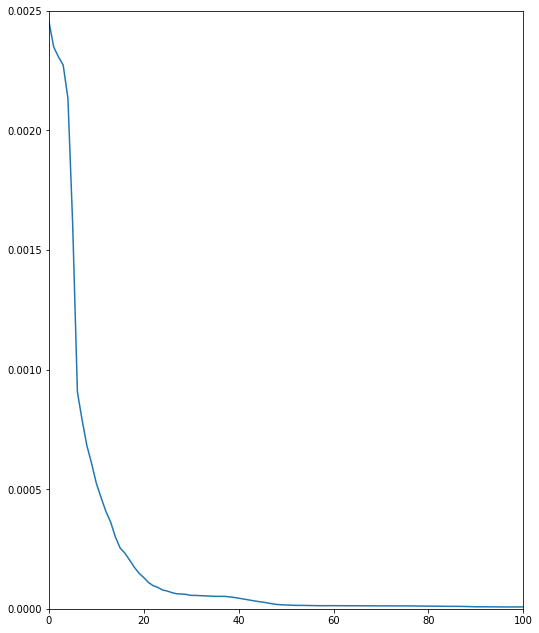

In [9]:
datafileDirectory = "/content/drive/My Drive/andre/"
#fileName = "257802-post_season_20161206_142914.edf"
fileName = "test.edf"

# caclPSD(datafileDirectory , fileName, channelNum, numTapers, samplingFrequency, timeBandWidth, timeWindow, stepSize, lowerFrequency, upperFrequency):
calcPSD("/content/drive/My Drive/andre/" , "test.edf" , 13, 6, 250, 4, 3, 2, 0, 100)
